численное решение уравнения диффузии

In [131]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

import scipy as scipy
from scipy.spatial.distance import euclidean

#from tqdm import tqdm_notebook
import time

from tqdm import tqdm

In [132]:
class Diffusion:
    # сетки
    def __init__(self):
        return
        
    def solve(self, Dp):
        L = 4*np.pi
        Nx = 51
        self.Nx = Nx
        Nt = 10001
        self.Nt = Nt
        T_end = 10
        self.x = np.linspace(0.1,L+0.1,Nx)
        
        left_cond = 0.4 # слева concentration
        right_cond = 0.4 # справа значение концентрации
        #CTR_0 = -10
        CTR_0 = np.exp(-(self.x - 2*np.pi)**2 / (2*np.pi))
        
        # parameters
        CTR = np.zeros((Nx, Nt))
        D = np.zeros((Nx,Nt))
        for j in range(Nt):
            D[:,j] = Dp[j*Nx:(j+1)*Nx]
        
        #print(np.shape(D))
        # boundaries
        CTR[:,0] = CTR_0
        CTR[0,:] = left_cond
        CTR[Nx-1,:] = right_cond
        
        A = np.zeros((Nx,Nx, Nt))
        b = np.zeros((Nx, Nt))
        
        
        dd = (L / (Nx-1))**2 / (T_end / (Nt - 1))
        b1 = np.zeros((Nx,Nx)) - dd
        
        def DD(i,j): 
            return 2*D[i,j]*D[i-1,j] / (D[i,j] + D[i-1,j])
        #def DD(i,j): return D[i,j] + D[i-1,j] / 2
        
        for j in range(Nt-1):
        
            A[0,0,j] = - (DD(1,j) + D[0,j] + dd)
            A[0,1,j] = DD(1,j)
            A[Nx-1,Nx-1,j] = -(DD(Nx-1,j) + D[Nx-1,j] + dd)
            A[Nx-1,Nx-2,j] = DD(Nx-1,j) 
            b[0,j] = - D[0,j] * left_cond - dd * CTR[0,j]
            b[Nx-1,j] = -D[Nx-1,j] * right_cond - dd * CTR[Nx-1,j]
            
            for i in range(1,Nx-1):
                A[i,i,j] = - (DD(i+1,j) + DD(i,j) + dd)
                A[i,i+1,j] = DD(i+1,j)
                b[i,j] = - dd * CTR[i,j]
            for i in range(1,Nx-1):
                A[i,i-1,j] = DD(i,j)
            
            
            CTR[:,j+1] = np.linalg.solve(A[:,:,j], b[:,j])
           
        
        CTR_f = np.zeros(Nx*Nt)
        for j in range(Nt):
            CTR_f[j*Nx:(j+1)*Nx] = CTR[:,j]
        
        self.solution = CTR_f
        return CTR_f, A, b, b1
    
    def cf_grad(self, D):
        Nx = self.Nx
        Nt = self.Nt
        C_fix = self.C_fix1

        lam = np.zeros((Nx,Nt))
        CTR_f, A, b, b1 = self.solve(D) 
        
        CTR = np.zeros((Nx, Nt))
        for j in range(Nt):
            CTR[:,j] = CTR_f[j*Nx:(j+1)*Nx]
        
        
        lam[:,Nt-1] = -(CTR[:,Nt-1] - C_fix[:,Nt-1]).T @ np.linalg.inv(A[:,:,Nt-2]) # Ваня ищет оператор
        
        for j in range(Nt-2,0,-1):
            lam[:,j] = - np.linalg.inv(A[:,:,j-1]) @ ((CTR[:,j] - C_fix[:,j]) + lam[:,j+1] @ (-b1))

        
        gu = np.zeros((Nx,Nx,Nt))
        
        for j in range(Nt-1):
            gu[0,0,j] = -CTR[0,j+1]
            gu[Nx-1,Nx-1,j] = -CTR[Nx-1,j+1]
            for i in range(1,Nx-1):
                gu[i,i,j] = CTR[i-1,j+1] - CTR[i,j+1]
                gu[i,i+1,j] = CTR[i+1,j+1] - CTR[i,j+1]
        
                
        grad = np.zeros(Nx * Nt)
        for j in range(Nt-1):
            grad[j*Nx:(j+1)*Nx] = lam[:,j+1] @ gu[:,:,j]
        
        grad = grad / (np.linalg.norm(grad) + 1e-8)
        #print(f"grad = {np.shape(grad)}")
        return grad
            
            
    
    def cost_function(self, D):
        sol, _,_,_ = self.solve(D)
        #val = np.sum(sol**2 - self.C_fix**2)
        val = (sol - self.C_fix).T @ (sol - self.C_fix) 
        
        return val / 2
    
    
    def initialize(self, C_fix):
        
        self.C_fix = C_fix
        C = np.zeros((self.Nx, self.Nt))
        for j in range(self.Nt):
            C[:,j] = C_fix[j*self.Nx:(j+1)*self.Nx]
        
        self.C_fix1 = C
    
    def plot(self, timesteps):
        [plt.plot(self.x, self.solution[tp*self.Nx: (tp+1)*self.Nx], ) for tp in timesteps]
        plt.show()

In [133]:
slvr = Diffusion()
x=np.linspace(0.1,4*np.pi+0.1,51)
#Dp = np.zeros(len(x)) + 0.5
#for i in range(len(x)):
#    if i % 2 == 1:
#        Dp[i] = 1
Dp =np.sin(x) + 1.1
#Dp = x
D = np.zeros(51*10001)
for j in range(10001):
    D[j*51:(j+1)*51] = Dp
#D = 0.6 * np.ones(11011)
%time slvr1 = Diffusion()

Wall time: 0 ns


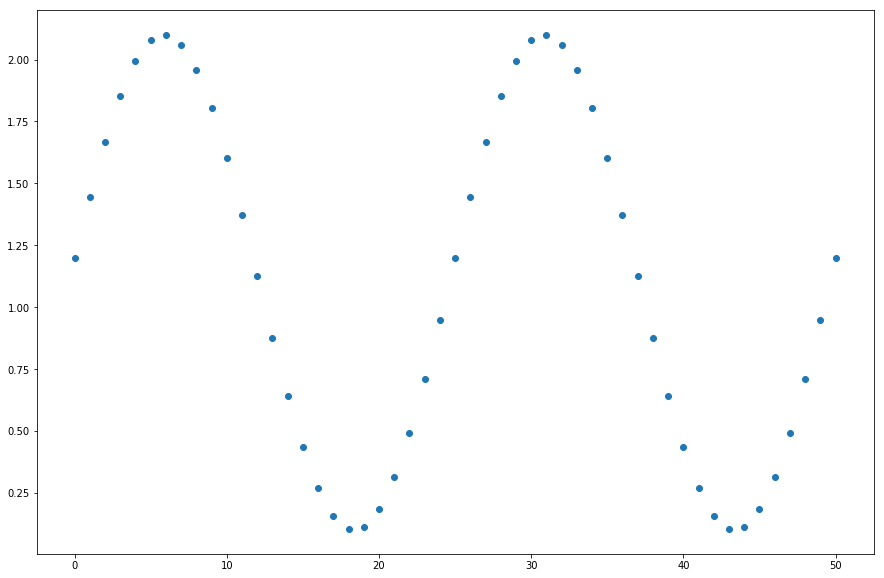

In [134]:
plt.plot(D[:51], 'o')

In [135]:
%time C1, A, b, b1 = slvr.solve(D)
%time Cfix, A, b, b1 = slvr1.solve(D)

Wall time: 3.13 s
Wall time: 3.07 s


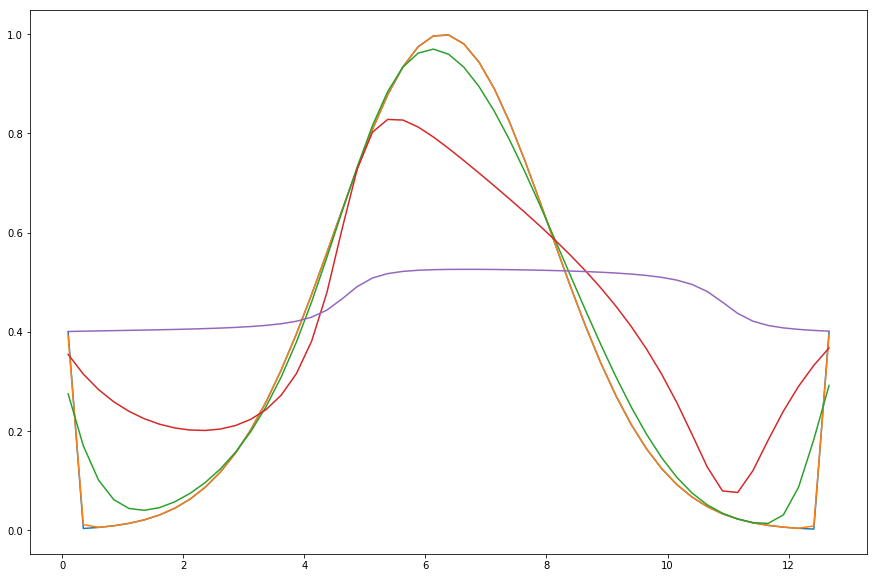

In [136]:

plt.figure()
slvr1.plot([0, 1, 100, 1000, 10000])

In [40]:
slvr.initialize(Cfix)

In [43]:
jaco = slvr.cf_grad(D)

In [44]:
jaco

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [ ]:
_ = plt.plot(jaco[:100])

In [ ]:
bb = np.random.random(size=len(D))

#x0 = D + bb - D.mean()
#x0 = np.linspace(0,100,lenD))
x0 = np.zeros(11011)

In [ ]:
len(x0)

In [ ]:
plt.figure()
plt.plot(D[:100], 'r')
plt.plot(x0[:100], 'b')

In [ ]:
slvr.cost_function(D+1)

In [ ]:
def GradientDescent(f, gradf, x0,  num_iter, eps, **kwargs):
    x_prev = x0.copy()
    
    iteration = 0

    less = False
    alpha = 10
    x_new = np.zeros(len(x_prev))
    
    sk_prev = - gradf(x_prev)
    while True:
        
        if less == True:
            alpha *= 0.5
            #sk_prev = sk_prev
            
            
        #else:
        #    sk_prev = - gradf(x_prev)

        x_new = x_prev + alpha * sk_prev
        
        
        
        
        gain = (x_new - x_prev) / x_prev
        if gain.T @ gain < eps:
            print(f"gain less that {eps}")
            break
        
        gradient = gradf(x_prev)
        g_new = gradf(x_new)
        #print()
        pr = (g_new.T @ (g_new - gradient)) / (gradient.T @ gradient)
        #fr = (g_new.T @ g_new) / (gradient.T @ gradient)
        w = np.maximum(0, pr)
        #w = fr    
        sk_prev = - g_new + sk_prev * w
        #sk_prev = sk_prev * w
        
        if (f(x_new) - f(x_prev)) < 0:
            
            x_prev = x_new
             
            
            alpha = 10
            less = False
            
        else:
            less = True
            
            
        print(f"CFV = {f(x_prev)}, less = {less}, alpha = {alpha}, GS = {np.sign(gradient.T @ g_new)}")
        
        iteration += 1

        if iteration >= num_iter:
            break
        
    res = x_prev
    return res

In [ ]:
%time res = GradientDescent(f = slvr.cost_function, x0=x0, gradf=slvr.cf_grad, num_iter=50000, eps=1e-8)

In [ ]:
plt.figure()
plt.plot(D[:100], 'r')
plt.plot(x0[:100], 'b')
plt.plot(res[:100], 'g')